# Assignment 2
### (a) Implement the classifier model with the training dataset without using smoothing and test it on the test dataset.

#### Name: Himanshu Ruhela
#### Roll No: 2018IMT-039
#### Course: Machine Learning Lab (ITIT-4107)
#### Deadline: 23:59, 25th September 2021

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import datasets
from tqdm import tqdm
from scipy.stats import multivariate_normal as mvn

import os
from time import time

from IPython.display import display, HTML
from itertools import chain

In [2]:
def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()

convert("train-images.idx3-ubyte", "train-labels.idx1-ubyte", "mnist_training_data.csv", 60000)
convert("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte", "mnist_test_data.csv", 10000)

In [3]:
df_train = pd.read_csv('mnist_training_data.csv')
df_test = pd.read_csv('mnist_test_data.csv')

df_train.rename(columns={'5':'label'}, inplace=True)
df_test.rename(columns={'7':'label'}, inplace=True)

df_train.to_csv('mnist_training_data.csv', index=False)
df_test.to_csv('mnist_test_data.csv', index=False)

Now, since the data is ready, we can work on the classification task.

In [4]:
df_train = pd.read_csv('mnist_training_data.csv')
df_test = pd.read_csv('mnist_test_data.csv')

Preview of the data prepared

In [5]:
df_train.head()

,label,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df_test.head()

,label,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.658,0.659,0.660,0.661,0.662,0.663,0.664,0.665,0.666,0.667
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
labels_train = df_train['label'].to_numpy()
df_digits = df_train.drop('label',axis=1)

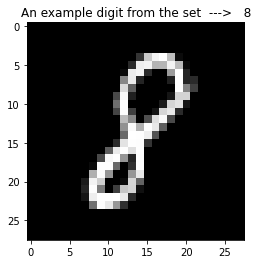

In [8]:
index = 1024
digits_data_train = df_digits.to_numpy()
digit = digits_data_train[index]

#flattening the matrix

digit = digit.reshape(28,28)
plt.title('An example digit from the set  --->   ' + str(labels_train[index]))
plt.imshow(digit, cmap='gray')

In [9]:
X_train=df_digits
y_train=df_train['label']

df_digits_test=df_test.drop('label',axis=1)

X_test=df_digits_test
y_test=df_test['label']

### NaiveBayes Classifier

In [10]:
class NaiveBayes():
    def prior(self, features, target):
        self.prior = (features.groupby(target).apply(lambda x: len(x)) / self.rows).to_numpy()
        return self.prior
    
    def parameters(self, features, target):
        self.mean = features.groupby(target).apply(np.mean).to_numpy()
        self.var = features.groupby(target).apply(np.var).to_numpy()
        return self.mean, self.var
    
    def gaussians(self, class_idx, x):     
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp((-1/2)*((x-mean)**2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        prob = numerator / denominator
        return prob
    
    def calc_posterior(self, x):
        posteriors = []
        for i in range(self.count):
            prior = np.log(self.prior[i])
            conditional = np.sum(np.log(self.gaussians(i, x)))
            posterior = prior + conditional
            posteriors.append(posterior)
        return self.classes[np.argmax(posteriors)]
     
    def fit(self, features, target):
        self.classes = np.unique(target)
        self.count = len(self.classes)
        self.feature_nums = features.shape[1]
        self.rows = features.shape[0]   
        self.parameters(features, target)
        self.prior(features, target)
        
    def predict(self, features):
        preds = [self.calc_posterior(f) for f in features.to_numpy()]
        return preds

    def accuracy(self, y_test, y_pred):
        accuracy = np.sum(y_test == y_pred) / len(y_test)
        return accuracy

Training the classifier and making the predictions

In [11]:
nb_model = NaiveBayes()
nb_model.fit(X_train, y_train)
y_pred_a = nb_model.predict(X_test)

c:\users\himanshu ruhela\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
c:\users\himanshu ruhela\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
c:\users\himanshu ruhela\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
c:\users\himanshu ruhela\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


In [12]:
print('\nClassification Report\n',classification_report(y_test, y_pred_a))


Classification Report
               precision    recall  f1-score   support

           0       0.10      1.00      0.18       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1027
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.10      9999
   macro avg       0.01      0.10      0.02      9999
weighted avg       0.01      0.10      0.02      9999



c:\users\himanshu ruhela\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
cm_a = confusion_matrix(y_test, y_pred_a)
per_class_accuracies = {}

classes = [*range(0,10)]
for idx, cls in enumerate(classes):
    true_negatives = np.sum(np.delete(np.delete(cm_a, idx, axis=0), idx, axis=1))
    true_positives = cm_a[idx, idx]
    per_class_accuracies[cls] = (true_positives + true_negatives) / np.sum(cm_a)

print("\nPer class accuracies -\n")
print(pd.DataFrame(per_class_accuracies,index = np.arange(1)).T)


Per class accuracies -

          0
0  0.098010
1  0.886489
2  0.896790
3  0.898990
4  0.901790
5  0.910791
6  0.904190
7  0.897290
8  0.902590
9  0.899090


### (b) Implement the classifier model with the training dataset using smoothing function and test it on the test dataset.

Since all the preprocessing is done, the modified classifier is used which uses a smoothing function.

In [14]:
def NaiveBayesSmoothing(X_train, y_train, X_test,smoothing):
    curve_data = dict()
    probab_prior= dict()
    training_label = set(y_train)
    #testing_label = set(y_test)
    for c in training_label:
        current_X = X_train[y_train==c]
        curve_data[c] = {'mean':current_X.mean(axis=0)+smoothing/2,'cov' :current_X.var(axis=0)+smoothing}
        probab_prior[c] = float(len([y_train==c]))/len(y_train)
        N, D = X_test.shape
        Probabilties = np.zeros((N, len(curve_data))) 
   
        for c, g in curve_data.items():
            mean, cov = g['mean'], g['cov']
            Probabilties[:,c] = mvn.logpdf(X_test, mean=mean, cov=cov) + np.log(probab_prior[c])
        y_hat = np.argmax(Probabilties, axis=1)
    
    return y_hat

In [15]:
y_pred_b = NaiveBayesSmoothing(X_train, y_train, X_test,10)

In [16]:
print('\nClassification Report\n')
print(classification_report(y_test, y_pred_b))


Classification Report

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       980
           1       0.87      0.95      0.91      1135
           2       0.87      0.71      0.79      1032
           3       0.80      0.77      0.78      1010
           4       0.83      0.61      0.70       982
           5       0.83      0.63      0.72       892
           6       0.82      0.92      0.87       958
           7       0.92      0.79      0.85      1027
           8       0.63      0.72      0.67       974
           9       0.59      0.89      0.71      1009

    accuracy                           0.79      9999
   macro avg       0.81      0.79      0.79      9999
weighted avg       0.81      0.79      0.79      9999



In [17]:
cm_b = confusion_matrix(y_test, y_pred_b)
per_class_accuracies = {}

classes = [*range(0,10)]
for idx, cls in enumerate(classes):
    true_negatives = np.sum(np.delete(np.delete(cm_b, idx, axis=0), idx, axis=1))
    true_positives = cm_b[idx, idx]
    per_class_accuracies[cls] = (true_positives + true_negatives) / np.sum(cm_b)
    
print("\nPer class accuracies -\n")
print(pd.DataFrame(per_class_accuracies,index = np.arange(1)).T)


Per class accuracies -

          0
0  0.982598
1  0.978798
2  0.959796
3  0.957196
4  0.949095
5  0.955996
6  0.973397
7  0.970597
8  0.931393
9  0.925693
